In [1]:
import os
import copy
import random

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

In [2]:
random.seed(142)
indoor_files = os.listdir("data/indoor-outdoor/indoor/")
indoor_files = random.sample(indoor_files, int(len(indoor_files) * 0.1))
train_indoor_files, test_indoor_files = train_test_split([os.path.join("data/indoor-outdoor/indoor/", file) for file in indoor_files], test_size=.3, random_state=42)

outdoor_files = os.listdir("data/indoor-outdoor/outdoor/")
outdoor_files = random.sample(outdoor_files, int(len(outdoor_files) * 0.1))
train_outdoor_files, test_outdoor_files = train_test_split([os.path.join("data/indoor-outdoor/outdoor/", file) for file in outdoor_files], test_size=.3, random_state=42)

In [3]:
train_files = train_indoor_files + train_outdoor_files
test_files = test_indoor_files + test_outdoor_files

print(f"Train size: {len(train_files)}, Test size: {len(test_files)}")

Train size: 65417, Test size: 28036


In [4]:
train_classes = [0] * len(train_indoor_files) + [1] * len(train_outdoor_files)
test_classes = [0] * len(test_indoor_files) + [1] * len(test_outdoor_files)

label2id = {"indoor": 0, "outdoor": 1}
id2label = {0: "indoor", 1: "outdoor"}

In [5]:
class IndoorOutdoorDataset(torch.utils.data.Dataset):
  def __init__(self, image_paths, labels, transform=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

  def __len__(self):
      return len(self.image_paths)

  def __getitem__(self, idx):
      image_filepath = self.image_paths[idx]
      image = cv2.imread(image_filepath)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      label = self.labels[idx]
      if self.transform is not None:
          image = self.transform(image=image)["image"]

      return image, label

In [6]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_dataset = IndoorOutdoorDataset(train_files, train_classes, train_transforms)
valid_dataset = IndoorOutdoorDataset(test_files, test_classes, test_transforms)

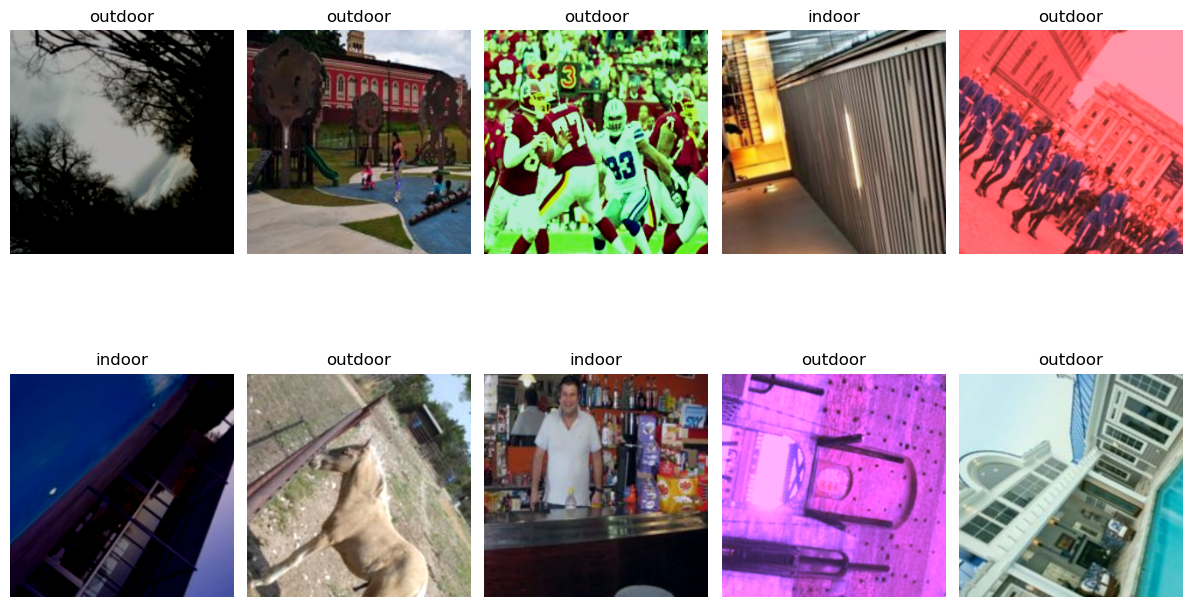

In [7]:
def visualize_dataset(dataset, idx=0, samples=10, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols

    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_files))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(id2label[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_dataset(train_dataset, np.random.randint(1, len(train_files)), random_img = True)


In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=128, shuffle=True, drop_last=True
)

next(iter(train_loader))[0].shape

torch.Size([128, 3, 256, 256])

In [9]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [11]:
def train(model, optimizer, train_dataloader, val_dataloader, n_epochs=10, device='cuda'):

    model = model.to(device)
    accuracies, f1_scores, losses = [], [], []
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        val_loss = []
        val_accuracy = []
        val_f1_score = []
        targets = []
        preds = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)

                _, predicted = torch.max(y_pred.data, 1)

                targets.extend(y_val.cpu().numpy().tolist())
                preds.extend(predicted.cpu().numpy().tolist())

                val_loss.append(loss.cpu().numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        accuracies.append(np.mean(val_accuracy))
        f1_scores.append(f1_score(targets, preds, average='weighted'))
        losses.append(np.mean(val_loss))
        print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}, f1_score: {f1_score(targets, preds, average="weighted")}')
    return accuracies, f1_scores, losses

In [12]:
accs, f1s, losses = train(model, optimizer, train_dataloader=train_loader, val_dataloader=test_loader, n_epochs=10)

100%|██████████| 219/219 [02:51<00:00,  1.28it/s]


Epoch: 0, loss: 0.3029007315635681, accuracy: 0.8705764840182648, f1_score: 0.8703739074790041


100%|██████████| 219/219 [00:47<00:00,  4.57it/s]


Epoch: 1, loss: 0.3073021173477173, accuracy: 0.8681506849315068, f1_score: 0.8694186573771252


100%|██████████| 219/219 [00:47<00:00,  4.56it/s]


Epoch: 2, loss: 0.26968395709991455, accuracy: 0.8837400114155252, f1_score: 0.8845399358175927


100%|██████████| 219/219 [00:47<00:00,  4.58it/s]


Epoch: 3, loss: 0.2634319067001343, accuracy: 0.8889126712328768, f1_score: 0.8893092648101848


100%|██████████| 219/219 [00:47<00:00,  4.60it/s]


Epoch: 4, loss: 0.2618676722049713, accuracy: 0.8917665525114156, f1_score: 0.8924781457634473


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch: 5, loss: 0.2458941787481308, accuracy: 0.8994006849315068, f1_score: 0.8997954664086548


100%|██████████| 219/219 [00:46<00:00,  4.69it/s]


Epoch: 6, loss: 0.25494086742401123, accuracy: 0.891980593607306, f1_score: 0.8929810990015475


100%|██████████| 219/219 [00:46<00:00,  4.71it/s]


Epoch: 7, loss: 0.2518306374549866, accuracy: 0.8944420662100456, f1_score: 0.8954016543417558


100%|██████████| 219/219 [00:46<00:00,  4.70it/s]


Epoch: 8, loss: 0.24400962889194489, accuracy: 0.897902397260274, f1_score: 0.8986048821459218


100%|██████████| 219/219 [00:46<00:00,  4.74it/s]

Epoch: 9, loss: 0.24926713109016418, accuracy: 0.8952982305936074, f1_score: 0.8958389104689098


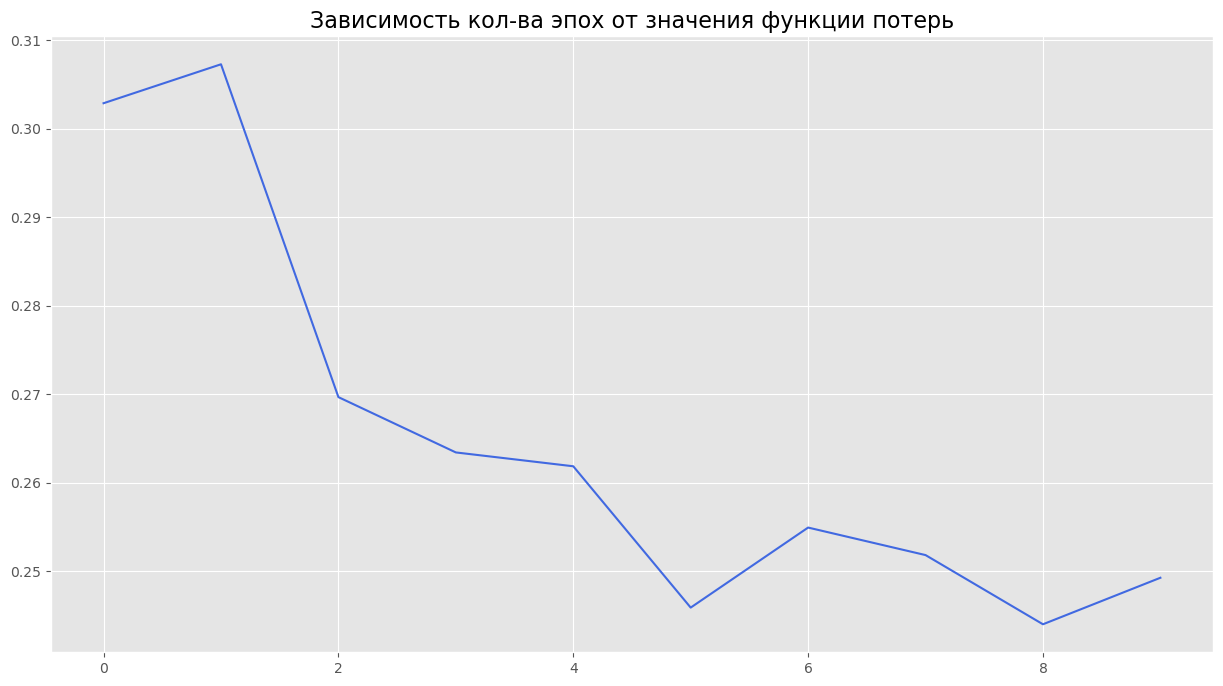

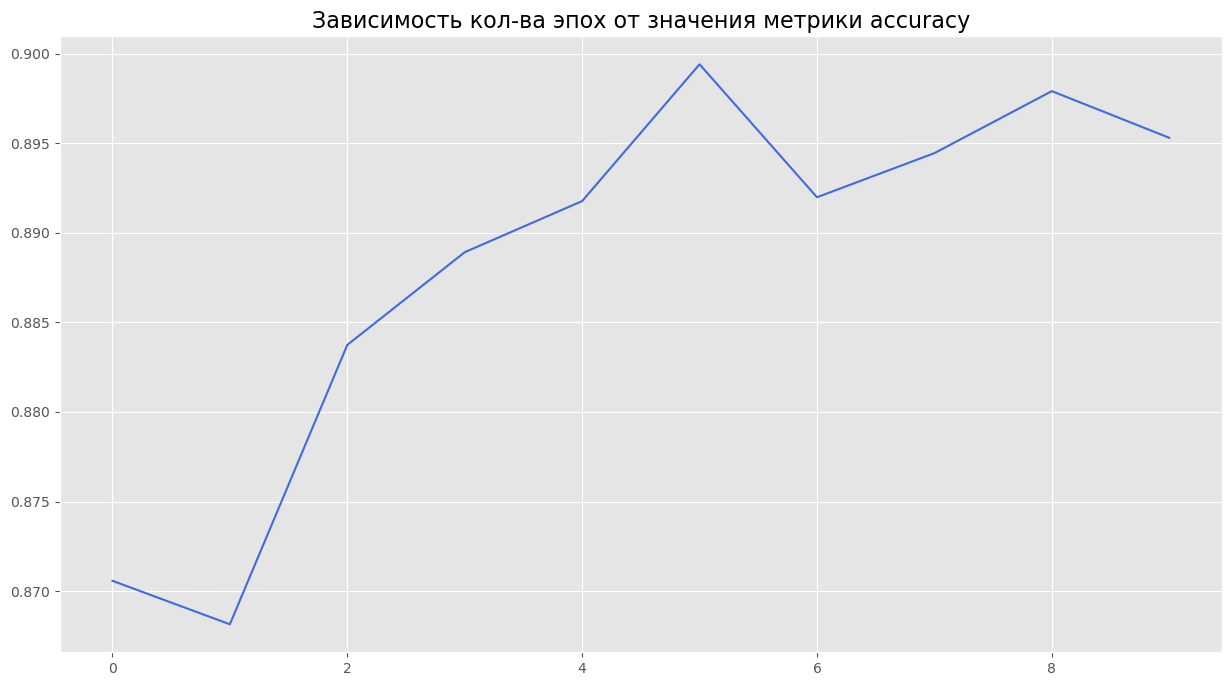

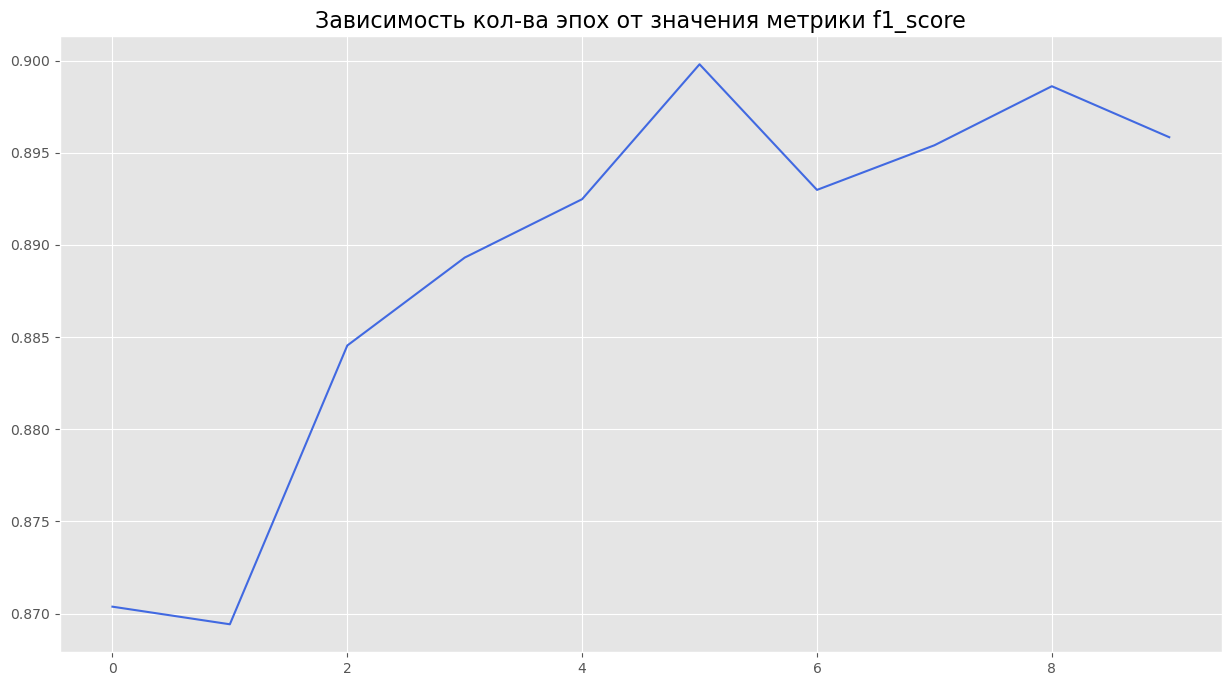

In [20]:
plt.style.use('ggplot')

def plot_metrics(metric, caption):
    plt.figure(figsize=(15, 8))
    plt.plot(list(range(0, 10)), metric, color="royalblue")
    plt.title(f'Зависимость кол-ва эпох от значения {caption}', fontsize=16)
    plt.grid(True)
    

plot_metrics(losses, 'функции потерь')
plot_metrics(accs, 'метрики accuracy')
plot_metrics(f1s, 'метрики f1_score')

Выводы:
- В силу небольшого количества вычислительных ресурсов было принято решение уменьшить датасет до 10% от всего набор данных.
- В качестве моделей рассматривались resnet18, resnet34 и resnet50. Чем больше слоев у модели, тем лучшего качества удавалось достичь.
- Изменение lr может привести как к росту качества, так и к ухудшению качества, тут явной закономерности нет, но лучше выбирать не сильно большое, не сильно маленькое значение, например, 1e-3.
- С увеличеним batch size качество росло и сходимость ускорялась, поэтому в итоге было выбрано максимальное значение, которое помещается в видеопамять.
- Добавление агументаций также позволило повысить качество и ускорить сходимость.
- accuracy и f1 score не сильно отличаются друг от друга, это говорит о хорошем балансе классов в обучении и валидации.